In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')
# the project's folder
%cd /gdrive/'My Drive'/object_detection

Mounted at /gdrive
/gdrive/My Drive/object_detection


In [ ]:
import os 
os.getcwd()

'/gdrive/My Drive/object_detection'

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow as tf
import cv2 


from PIL import Image
from collections import namedtuple, OrderedDict

from google.colab import files

In [ ]:
# downloads the mask rcnn model
#!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
#installing mask rcnn library
os.chdir('Mask_RCNN')
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/parallel_model.py to p

In [ ]:
# import libs
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import pylab
import random
from tqdm import tqdm
import time
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray

# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import MaskRCNN
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


In [ ]:
import os
import sys
import json
import datetime
import numpy as np
from numpy import expand_dims
from numpy import mean
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import skimage.draw
import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io
import pylab
import random
from tqdm import tqdm
import time

In [ ]:
#checking if mask rcnn library has been installed
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


In [ ]:
class_names = ['AlliedElectronics','Always','AppliedUnderwriters','BASF','Bayer','BotoxCosmetic','EgglandsBest',
               'Enlist','FarmProgress','Geico','Jergens','Kellogs','Kenworth','Kraft','LGSeeds','Laufenn',
               'Lunchables','NaturalAmericanSpirit','Nexium','Nitto','PepperidgeFarm','TDAmeritrade','Tampax',
               'Toyota','Twix']

In [ ]:
class CustomConfig(Config):
  NAME = "ads"
# Give the configuration a recognizable name    NAME = category     # We use a GPU with 12GB memory, which can fit two images.    
# Adjust down if you use a smaller GPU.   
  IMAGES_PER_GPU = 1     
# Number of classes (including background)   
  NUM_CLASSES = 1 + len(class_names)  
# Defining the batch size 
  BATCH_SIZE = 1
# Background + toy     
# Number of training steps per epoch    
  STEPS_PER_EPOCH = 100     
# Skip detections with < 90% confidence    
  DETECTION_MIN_CONFIDENCE = 0.9
# Backbone network architecture
  # Supported values are: resnet50, resnet101
  BACKBONE = "resnet50"
# Input image resizing
  IMAGE_RESIZE_MODE = "crop"
  IMAGE_MIN_DIM = 128
  IMAGE_MAX_DIM = 128
  IMAGE_MIN_SCALE = 2.0
# ROIs kept after non-maximum supression (training and inference)
  POST_NMS_ROIS_TRAINING = 1000
  POST_NMS_ROIS_INFERENCE = 2000
# Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
  RPN_NMS_THRESHOLD = 0.9
# How many anchors per image to use for RPN training
  RPN_TRAIN_ANCHORS_PER_IMAGE = 64
# If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
  USE_MINI_MASK = False
  MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask

#Creating the Data set

In [ ]:
############################################################
#  Dataset
############################################################
class CustomDataset(utils.Dataset):
    def load_custom(self, dataset_dir, subset):

      for i in range(1,len(class_names)+1):
        self.add_class(category, i, class_names[i-1])
        # define data locations
      images_dir = dataset_dir + '/images/'
      annotations_dir = dataset_dir + '/annots/'

      for filename in listdir(images_dir):
        image_id = filename[:-4]
        img_path = images_dir + filename
        ann_path = annotations_dir + image_id + '.xml'
        self.add_image(category, image_id=image_id, path=img_path, annotation=ann_path)
 # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
		      # load and parse the file
      tree = ElementTree.parse(filename)
		      # get the root of the document
      root = tree.getroot()
		      # extract each bounding box
      boxes = list()
      classes_names=list()    
      for member in root.findall('object'):
        classes_names.append(member[0].text)
      classes_names = list(set(classes_names))
      for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
		      # extract image dimensions  
      width = int(root.find('.//size/width').text)
      height = int(root.find('.//size/height').text)
      return boxes, width, height ,classes_names




    def load_mask(self, image_id):
      
      info = self.image_info[image_id]
      path = info['annotation']
      boxes, w, h , classes_names = self.extract_boxes(path)
      masks = zeros([h, w, len(boxes)], dtype='uint8')
      class_ids = list()
      
      for i in range(len(boxes)):
        box = boxes[i]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        
        for i in classes_names :
          class_ids.append(self.class_names.index(i))
      return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
      info = self.image_info[image_id]
      return info['path']

In [ ]:
dataset_dir = '/gdrive/My Drive/object_detection/data/mask_rcnn/datasets/train'

In [ ]:
category='ads'

In [ ]:
valset_dir = '/gdrive/My Drive/object_detection/data/mask_rcnn/datasets/val'

In [ ]:

    # Training dataset.
dataset_train = CustomDataset()
dataset_train.load_custom(dataset_dir, "train")
dataset_train.prepare()

    # Validation dataset
dataset_val = CustomDataset()
dataset_val.load_custom(valset_dir, "val")
dataset_val.prepare()


In [ ]:
print('Train: %d' % len(dataset_train.image_ids))

Train: 425


In [ ]:
print('Test: %d' % len(dataset_val.image_ids))

Test: 54


[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]] [10]


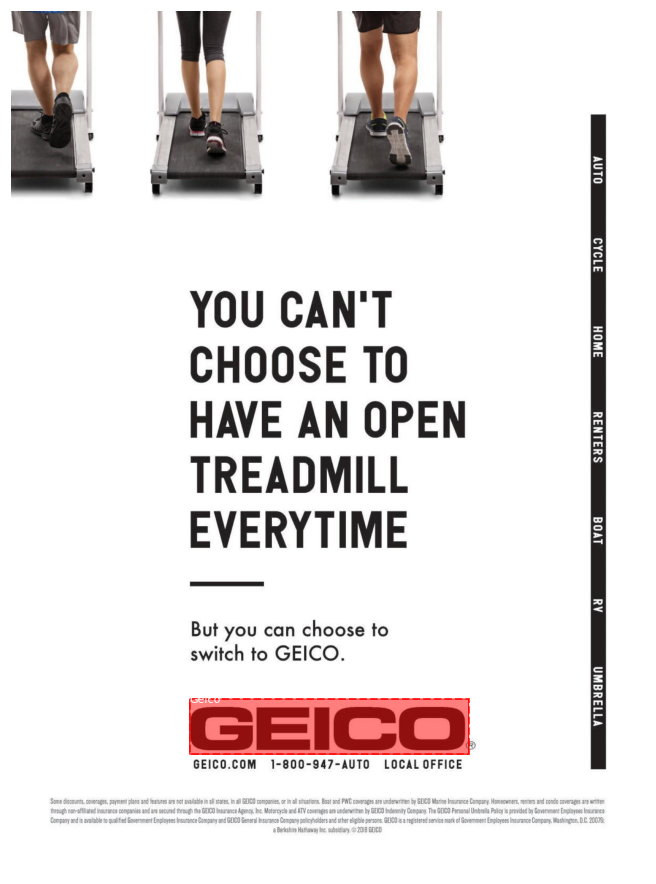

In [ ]:
# define image id
image_id = 1
# load the image
image = dataset_train.load_image(image_id)
# load the masks and the class ids
mask, class_ids = dataset_train.load_mask(image_id)
print(mask , class_ids)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

In [ ]:
from datetime import datetime
now = datetime.now()
print(now)

2020-11-02 13:00:59.036559


In [ ]:
config = CustomConfig()

In [ ]:
os.getcwd()

'/gdrive/My Drive/object_detection/Mask_RCNN'

In [ ]:
model = MaskRCNN(mode='training', model_dir='./', config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
# train weights (output layers or 'heads')
history = model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE, epochs=200, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./ads20201102T1301/mask_rcnn_ads_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
  6/100 [>.............................] - ETA: 25:16 - loss: 6.7031

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 2594s 26s/step - loss: 4.3061 - val_loss: 2.5882

Epoch 2/200
100/100 [==============================] - 1938s 19s/step - loss: 4.3354 - val_loss: 3.8703
Epoch 3/200
100/100 [==============================] - 1571s 16s/step - loss: 3.5963 - val_loss: 2.8317
Epoch 4/200
100/100 [==============================] - 1847s 18s/step - loss: 3.8078 - val_loss: 2.9297
Epoch 5/200
100/100 [==============================] - 2025s 20s/step - loss: 3.2018 - val_loss: 5.8670
Epoch 6/200
100/100 [==============================] - 1714s 17s/step - loss: 3.1012 - val_loss: 2.0713
Epoch 7/200
100/100 [==============================] - 2080s 21s/step - loss: 2.8670 - val_loss: 4.7287
Epoch 8/200
100/100 [==============================] - 2041s 20s/step - loss: 3.1665 - val_loss: 3.2223
Epoch 9/200
100/100 [==============================] - 1562s 16s/step - loss: 2.9691 - val_loss: 2.5557
Epoch 10/200
100/100 [==============================] - 1778s 18s/step - lo

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py", line 650, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/gdrive/My Drive/object_detection/Mask_RCNN/mrcnn/model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/l

KeyboardInterrupt: ignored

In [ ]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "ads"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + len(class_names)
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [ ]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

In [ ]:
model.load_weights('./ads20201101T1824/mask_rcnn_ads_0200.h5', by_name=True)

In [ ]:
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
	  image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
	  scaled_image = mold_image(image, cfg)
		# convert image into one sample
	  sample = expand_dims(scaled_image, 0)
		# make prediction
	  yhat = model.detect(sample, verbose=0)
		# extract results for first sample
	  r = yhat[0]
		# calculate statistics, including AP
	  AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
	  APs.append(AP)
	# calculate the mean AP across all images
  mAP = mean(APs)
  return mAP

In [ ]:
train_mAP = evaluate_model(dataset_train, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(dataset_val, model, cfg)
print("Test mAP: %.3f" % test_mAP)

In [ ]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=2):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		pyplot.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		pyplot.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		pyplot.imshow(image)
		pyplot.title('Predicted')
		ax = pyplot.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	pyplot.show()

In [ ]:
plot_actual_vs_predicted(dataset_train, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(dataset_val, model, cfg)